#### Indirect Inference

In [2]:
# Real Model
mu <- 0
rho <- 0.9
sigma2 <- 0.32**2
theta <- c(mu, rho, sigma2)
h0 <- mu
T <- 2000

In [3]:
sv_simul <- function(theta, h0, T){
    y_t = c()
    h_t = c()
    mu <- theta[1]
    rho <- theta[2]
    sigma2 <- theta[3]
    
    u_t <- rnorm(T, 0, 1)
    v_t <- rnorm(T, 0, sqrt(sigma2))
    
    h_t[1] <- mu + rho * h0 + v_t[1]
    y_t[1] <- exp(0.5 * h_t[1]) * u_t[1]
    
    for (t in 2:T){
        h_t[t] <- mu + rho * h_t[t-1] + v_t[t]
        y_t[t] <- exp(0.5 * h_t[t]) * u_t[t]
    }
    list(y_t, h_t)
}

In [4]:
data <- sv_simul(theta, h0, T)
y_t <- unlist(data[1])
h_t <- unlist(data[2])

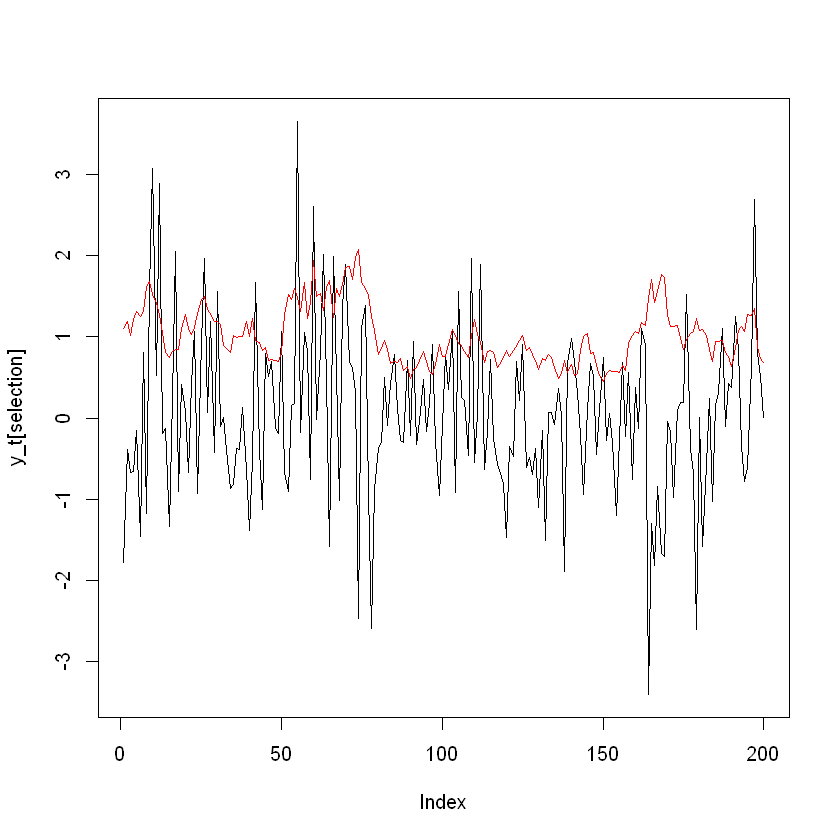

In [5]:
selection <- 1:200
plot(y_t[selection], type='l')
lines(sqrt(exp(h_t[selection])), type='l', col='red')

In [6]:
sum(y_t == 0)

[1] 0

### Auxiliary Model

In [7]:
alpha_init <- c(0.1, 0.5, 0.5, 5)

In [8]:
x_t <- log(y_t**2) * (y_t!=0)
    x_t <- x_t[x_t!=0]

In [13]:
arma10 <- arima(x_t, order = c(10, 0, 0), include.mean = FALSE)  # uses ARIMA(p,d,q) specification
arma_coefarma10$coef

ar1        ar2        ar3        ar4        ar5        ar6        ar7 
0.09604219 0.11176350 0.13163156 0.06875119 0.07841894 0.08008219 0.05048225 
       ar8        ar9       ar10 
0.06525569 0.04422009 0.04037824

##### 1st version

In [95]:
obj_aux_ar <- function(alpha, x_t){
    T <- length(x_t)
    w_t <- c()
    alpha_star <- alpha[1:3]
    alpha0 <- alpha_star[1]
    alpha1 <- alpha_star[2]
    alpha2 <- alpha_star[3]
    nu2 <- alpha[4]
    w0 <- 0
    x0 <- alpha0 / (1 - alpha1)
    
    w_t[1] <- x_t[1] - alpha0 - alpha1*x0 + alpha2*w0
    for (t in 2:T){
        w_t[t] = x_t[t] - alpha0 - alpha1 * x_t[t-1] + alpha2 * w_t[t-1]    
    }
    pml <- -1/2 * log(2*pi) - 1/2 * log(nu2) - 1/(2*T*nu2) * sum(w_t**2)
    -pml
}

In [96]:
estim_aux_arma <- function(alpha_init, y_t){
    valinit <- alpha_init
    lower = c(-1, -0.2, -0.2, 1e-2)
    upper = c(1, 2, 2, 10)
    x_t <- log(y_t**2) * (y_t!=0)
    x_t <- x_t[x_t!=0]
    res <- nlminb(valinit, obj_aux_arma, lower=lower, upper=upper, x_t=x_t)
    alpha0 <- res$par[1]
    alpha1 <- res$par[2]
    alpha2 <- res$par[3]
    nu2 <- res$par[4]
    list(coef=c(alpha0, alpha1, alpha2, nu2))
}

In [97]:
estimation <- estim_aux_arma(alpha_init, y_t)
alpha_hat <- estimation$coef
alpha_hat <- matrix(alpha_hat)

In [98]:
alpha_hat

-0.1497240
0.8802482
0.8075766
5.5993499


### Simulations

In [99]:
# Inputs
H <- 16
h0 <- 0.0001
theta0 <- c(0, 0.8, 0.4**2)

In [100]:
minim_crit_arma <- function(theta, T, H, h0, alpha_init, alpha_hat){
    data_sim <- sv_simul(theta, h0, T*H)
    y_sim <- unlist(data_sim[1])
    estimation <- estim_aux_arma(alpha_init, y_sim)
    alpha_sim <- estimation$coef
    alpha_sim <- matrix(alpha_sim, nrow=4, ncol=1)
    Omega <- diag(4)*1
    crit <- as.numeric(t(alpha_hat - alpha_sim) %*% Omega %*% (alpha_hat - alpha_sim))
    crit
}

In [101]:
estim_sv_ind_inf_arma <- function(theta0, T, H, h0, alpha_init, alpha_hat){
    valinit <- theta0
    lower <- c(-.0001, 0.5, 0)
    upper <- c(.0001, 1, 0.5)
    res <- nlminb(valinit, minim_crit_arma, lower=lower, upper=upper,
                  T=T, H=H, h0=h0, alpha_init=alpha_init, alpha_hat=alpha_hat)
    theta_hat <- res$par
    theta_hat
}

In [102]:
start.time <- Sys.time()

In [ ]:
estimation <- estim_sv_ind_inf_arma(theta0, T, H, h0, alpha_init, alpha_hat);
theta_hat <- estimation
theta_hat - theta

In [ ]:
end.time <- Sys.time()
time.taken<-round(end.time-start.time,2)
time.taken

In [ ]:
theta0
theta_hat
theta

### Monte Carlo Experiment

In [74]:
start.time <- Sys.time()

In [75]:
# Inputs
M <- 10

In [ ]:
spread_conso <- matrix(0, nrow=M, ncol=3)

for (j in 1:M){
    # Simulation
    data <- sv_simul(theta, h0, T)
    y_t <- unlist(data[1])
    h_t <- unlist(data[2])
    
    # Estimation of the Auxiliary Model
    estimation <- estim_aux_arma(alpha_init, y_t)
    alpha_hat <- estimation$coef
    alpha_hat <- matrix(alpha_hat)
    
    # Estimation of the Auxiliary Model Simulated
    estimation <- estim_sv_ind_inf_arma(theta0, T, H, h0, alpha_init, alpha_hat)
    theta_hat <- estimation
    
    spread_conso[j,] <- theta_hat - theta
}

Warning message in nlminb(valinit, obj_aux_arma, lower = lower, upper = upper, x_t = x_t):
"NA/NaN function evaluation"
Warning message in nlminb(valinit, obj_aux_arma, lower = lower, upper = upper, x_t = x_t):
"NA/NaN function evaluation"
Warning message in nlminb(valinit, obj_aux_arma, lower = lower, upper = upper, x_t = x_t):
"NA/NaN function evaluation"
Warning message in nlminb(valinit, obj_aux_arma, lower = lower, upper = upper, x_t = x_t):
"NA/NaN function evaluation"
Warning message in nlminb(valinit, obj_aux_arma, lower = lower, upper = upper, x_t = x_t):
"NA/NaN function evaluation"
Warning message in nlminb(valinit, obj_aux_arma, lower = lower, upper = upper, x_t = x_t):
"NA/NaN function evaluation"
Warning message in nlminb(valinit, obj_aux_arma, lower = lower, upper = upper, x_t = x_t):
"NA/NaN function evaluation"
Warning message in nlminb(valinit, obj_aux_arma, lower = lower, upper = upper, x_t = x_t):
"NA/NaN function evaluation"
Warning message in nlminb(valinit, obj_a

In [ ]:
end.time <- Sys.time()
time.taken<-round(end.time-start.time,2)
time.taken

In [ ]:
mean(spread_conso[,1])
mean(spread_conso[,2])
mean(spread_conso[,3])

In [ ]:
boxplot(spread_conso[,1])
boxplot(spread_conso[,2])
boxplot(spread_conso[,3])

In [ ]:
mean(spread_conso[,1])
mean(spread_conso[,2])
mean(spread_conso[,3])

In [ ]:
theta
theta_hat